# 0. Importing Necessary Packages

In [1]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information

Software versions
Python 3.7.9 64bit [GCC 7.3.0]
IPython 7.16.1
OS Linux 5.8.18 100.fc31.x86_64 x86_64 with fedora 31 Thirty_One
Sun Mar 27 17:36:51 2022 KST

In [2]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'scipy', 'matplotlib', 'astropy']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.0
scipy: ver 1.6.2
matplotlib: ver 3.2.2
astropy: ver 4.2.1


In [3]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits

# 1. Inspecting the Data

In [4]:
current_dir = os.path.abspath(".")
raw_dir = current_dir+"/NGC3367/0_raw/"
bias_list = sorted(glob.glob(raw_dir+"cal*bias.fit"))
dark_list = sorted(glob.glob(raw_dir+"cal*dk*.fit"))
flat_list = sorted(glob.glob(raw_dir+"skyflat*.fit"))
sci_list  = sorted(glob.glob(raw_dir+"NGC3367*.fit"))
print(f"Bias: {len(bias_list):d} frames")
print(f"Dark: {len(dark_list):d} frames")
print(f"Flat (sky): {len(flat_list):d} frames")
print(f"Science (object): {len(sci_list):d} frames")

Bias: 9 frames
Dark: 27 frames
Flat (sky): 7 frames
Science (object): 1 frames


In [5]:
fits.open(sci_list[0]).info()

Filename: /data/jlee/DATA/TA/2022A/Class1/NGC3367/0_raw/NGC3367-0001R.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   (3192, 2129)   int16 (rescales to uint16)   


In [6]:
data, hdr = fits.getdata(sci_list[0], header=True)
hdr

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 3192 /fastest changing axis                           
NAXIS2  =                 2129 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2022-03-20T13:52:47' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   120.00000000000000 /Exposure time in seconds                        
EXPOSURE=   120.00000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.014793395996094 /CCD temperature at start of exposure in C       
XPIXSZ  =   11.2799999999999

In [7]:
for keys in ['DATE-OBS', 'EXPTIME', 'FILTER', 'INSTRUME']:
    print(keys+" = "+str(hdr[keys]))

DATE-OBS = 2022-03-20T13:52:47
EXPTIME = 120.0
FILTER = R
INSTRUME = Moravian Instruments, C3-61000EC PRO


<IPython.core.display.Javascript object>


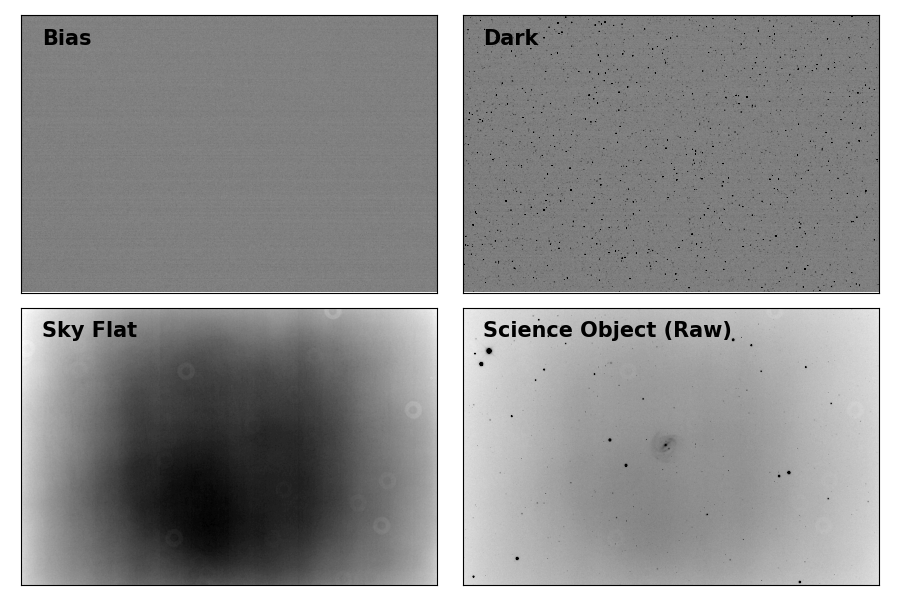

In [8]:
bias0 = fits.getdata(bias_list[0])
dark0 = fits.getdata(dark_list[0])
flat0 = fits.getdata(flat_list[0])
sci0  = fits.getdata(sci_list[0])
label = ["Bias", "Dark", "Sky Flat", "Science Object (Raw)"]

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

fig, axs = plt.subplots(2, 2, figsize=(9,6))
for i, img0 in enumerate([bias0, dark0, flat0, sci0]):
    vmin, vmax = interval.get_limits(img0)
    ax = axs[i // 2][i % 2]
    ax.imshow(img0, cmap='gray_r', origin='lower', vmin=vmin, vmax=vmax)
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
    ax.text(0.05, 0.95, label[i], fontsize=15.0, fontweight='bold',
            transform=ax.transAxes, ha='left', va='top')
plt.tight_layout()

In [9]:
ds9_options = "-scalemode zscale -scale lock yes -frame lock image -tile grid mode manual -tile grid layout 4 1"
os.system("ds9 "+bias_list[0]+" "+dark_list[0]+" "+flat_list[0]+" "+sci_list[0]+" "+ds9_options+" &")

0

# 2. Combining the Frames

### 1) Creating a Master Bias

In [10]:
for i in np.arange(len(bias_list)):
    bias_hdr = fits.getheader(bias_list[i])
    print(f"\nBias frame {i+1:d}")
    for keys in ['DATE-OBS', 'EXPTIME']:
        print("  "+keys+" = "+str(bias_hdr[keys]))


Bias frame 1
  DATE-OBS = 2022-03-20T19:52:14
  EXPTIME = 0.0

Bias frame 2
  DATE-OBS = 2022-03-20T19:52:22
  EXPTIME = 0.0

Bias frame 3
  DATE-OBS = 2022-03-20T19:52:29
  EXPTIME = 0.0

Bias frame 4
  DATE-OBS = 2022-03-20T19:52:37
  EXPTIME = 0.0

Bias frame 5
  DATE-OBS = 2022-03-20T19:52:44
  EXPTIME = 0.0

Bias frame 6
  DATE-OBS = 2022-03-20T19:52:52
  EXPTIME = 0.0

Bias frame 7
  DATE-OBS = 2022-03-20T19:53:00
  EXPTIME = 0.0

Bias frame 8
  DATE-OBS = 2022-03-20T19:53:07
  EXPTIME = 0.0

Bias frame 9
  DATE-OBS = 2022-03-20T19:53:14
  EXPTIME = 0.0


In [11]:
bias_array = np.zeros((len(bias_list), bias0.shape[0], bias0.shape[1]))
for i in np.arange(len(bias_list)):
    bias_data = fits.getdata(bias_list[i])
    bias_array[i, :, :] = bias_data
#bias_array[0, :, :]    # Data from bias_list[0]
#bias_array[1, :, :]    # Data from bias_list[1]

In [12]:
bias_med = np.median(bias_array, axis=0)    # Median combine
print(bias_array[:, 120-1, 100-1])    # Check data from each bias frame at (X,Y) = (100, 120)
print(bias_med[120-1, 100-1])    # Check data from median combined bias at (X,Y) = (100, 120)

[513. 510. 512. 514. 515. 514. 510. 515. 513.]
513.0


<IPython.core.display.Javascript object>


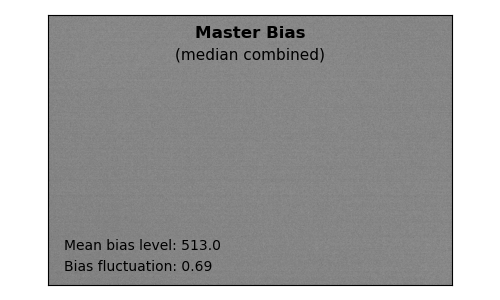

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
vmin, vmax = interval.get_limits(bias_med)
ax.imshow(bias_med, cmap='gray_r', origin='lower', vmin=vmin, vmax=vmax)
ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
ax.text(0.50, 0.96, "Master Bias", fontsize=12.0, fontweight='bold',
        transform=ax.transAxes, ha='center', va='top')
ax.text(0.50, 0.88, "(median combined)", fontsize=11.0,
        transform=ax.transAxes, ha='center', va='top')
ax.text(0.04, 0.12, f"Mean bias level: {np.mean(bias_med):.1f}", fontsize=10.0,
        transform=ax.transAxes, ha='left', va='bottom')
ax.text(0.04, 0.04, f"Bias fluctuation: {np.std(bias_med):.2f}", fontsize=10.0,
        transform=ax.transAxes, ha='left', va='bottom')
plt.tight_layout()

# # If you want to save this data to FITS file, please comment out the following line and run it.
# fits.writeto("MBias.fits", bias_med, overwrite=True)

### 2) Creating a Master Dark

In [14]:
for i in np.arange(len(dark_list)):
    dark_hdr = fits.getheader(dark_list[i])
    print(f"\nDark frame {i+1:d}")
    for keys in ['DATE-OBS', 'EXPTIME']:
        print("  "+keys+" = "+str(dark_hdr[keys]))


Dark frame 1
  DATE-OBS = 2022-03-20T19:56:26
  EXPTIME = 120.0

Dark frame 2
  DATE-OBS = 2022-03-20T19:53:22
  EXPTIME = 2.0

Dark frame 3
  DATE-OBS = 2022-03-20T19:54:45
  EXPTIME = 4.0

Dark frame 4
  DATE-OBS = 2022-03-20T19:58:33
  EXPTIME = 120.0

Dark frame 5
  DATE-OBS = 2022-03-20T19:53:31
  EXPTIME = 2.0

Dark frame 6
  DATE-OBS = 2022-03-20T19:54:57
  EXPTIME = 4.0

Dark frame 7
  DATE-OBS = 2022-03-20T20:00:40
  EXPTIME = 120.0

Dark frame 8
  DATE-OBS = 2022-03-20T19:53:40
  EXPTIME = 2.0

Dark frame 9
  DATE-OBS = 2022-03-20T19:55:08
  EXPTIME = 4.0

Dark frame 10
  DATE-OBS = 2022-03-20T20:02:48
  EXPTIME = 120.0

Dark frame 11
  DATE-OBS = 2022-03-20T19:53:50
  EXPTIME = 2.0

Dark frame 12
  DATE-OBS = 2022-03-20T19:55:19
  EXPTIME = 4.0

Dark frame 13
  DATE-OBS = 2022-03-20T20:04:55
  EXPTIME = 120.0

Dark frame 14
  DATE-OBS = 2022-03-20T19:53:59
  EXPTIME = 2.0

Dark frame 15
  DATE-OBS = 2022-03-20T19:55:30
  EXPTIME = 4.0

Dark frame 16
  DATE-OBS = 2022-03-20T

In [15]:
dark_array = np.zeros((len(dark_list), dark0.shape[0], dark0.shape[1]))
for i in np.arange(len(dark_list)):
    dark_data, dark_hdr = fits.getdata(dark_list[i], header=True)    
    dark_array[i, :, :] = (dark_data - bias_med) / dark_hdr['EXPTIME']
dark_med = np.median(dark_array, axis=0)    # Median combine
print(dark_array[:, 120-1, 100-1])    # Check data from each dark frame at (X,Y) = (100, 120)
print(dark_med[120-1, 100-1])    # Check data from median combined dark at (X,Y) = (100, 120)

[-0.01666667 -0.5         0.5         0.00833333 -1.          0.5
  0.00833333  0.          0.         -0.00833333  0.          0.
  0.         -1.         -0.25        0.00833333 -0.5         0.
  0.         -0.5        -0.25        0.          0.          0.5
  0.         -1.         -0.25      ]
0.0


In [16]:
dark_med[dark_med < 0.] = 0.    # Correcting the negative values (physically impossible)

<IPython.core.display.Javascript object>


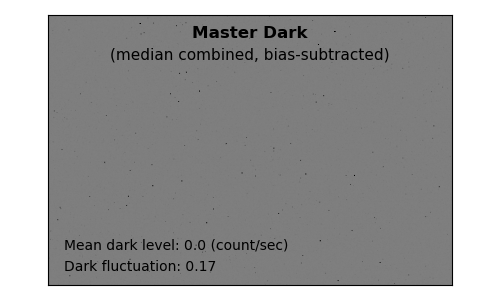

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.imshow(dark_med, cmap='gray_r', origin='lower', vmin=-1.0, vmax=1.0)
ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
ax.text(0.50, 0.96, "Master Dark", fontsize=12.0, fontweight='bold',
        transform=ax.transAxes, ha='center', va='top')
ax.text(0.50, 0.88, "(median combined, bias-subtracted)", fontsize=11.0,
        transform=ax.transAxes, ha='center', va='top')
ax.text(0.04, 0.12, f"Mean dark level: {np.mean(dark_med):.1f} (count/sec)", fontsize=10.0,
        transform=ax.transAxes, ha='left', va='bottom')
ax.text(0.04, 0.04, f"Dark fluctuation: {np.std(dark_med):.2f}", fontsize=10.0,
        transform=ax.transAxes, ha='left', va='bottom')
plt.tight_layout()

### 3) Creating a Mater Flat (for R band)

In [18]:
for i in np.arange(len(flat_list)):
    flat_hdr = fits.getheader(flat_list[i])
    print(f"\nFlat frame {i+1:d}")
    for keys in ['DATE-OBS', 'EXPTIME', 'FILTER']:
        print("  "+keys+" = "+str(flat_hdr[keys]))


Flat frame 1
  DATE-OBS = 2022-03-20T09:49:21
  EXPTIME = 2.0
  FILTER = R

Flat frame 2
  DATE-OBS = 2022-03-20T09:49:30
  EXPTIME = 2.0
  FILTER = R

Flat frame 3
  DATE-OBS = 2022-03-20T09:49:37
  EXPTIME = 2.0
  FILTER = R

Flat frame 4
  DATE-OBS = 2022-03-20T09:49:45
  EXPTIME = 2.0
  FILTER = R

Flat frame 5
  DATE-OBS = 2022-03-20T09:49:53
  EXPTIME = 2.0
  FILTER = R

Flat frame 6
  DATE-OBS = 2022-03-20T09:50:01
  EXPTIME = 2.0
  FILTER = R

Flat frame 7
  DATE-OBS = 2022-03-20T09:50:08
  EXPTIME = 2.0
  FILTER = R


In [19]:
flat_array = np.zeros((len(flat_list), flat0.shape[0], flat0.shape[1]))
for i in np.arange(len(flat_list)):
    flat_data, flat_hdr = fits.getdata(flat_list[i], header=True)    
    flat_array[i, :, :] = (flat_data - bias_med - dark_med*flat_hdr['EXPTIME'])
flat_med = np.median(flat_array, axis=0)    # Median combine
print(flat_array[:, 120-1, 100-1])    # Check data from each dark frame at (X,Y) = (100, 120)
print(flat_med[120-1, 100-1])    # Check data from median combined dark at (X,Y) = (100, 120)

[34212. 33707. 33598. 33678. 34694. 34837. 34076.]
34076.0


In [20]:
flat_med /= flat_med.max()    # Flat scaling (with relative sensitivity = 1 at the maximum data point)

<IPython.core.display.Javascript object>


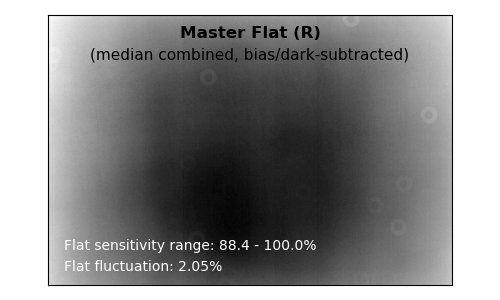

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
vmin, vmax = interval.get_limits(flat_med)
ax.imshow(flat_med, cmap='gray_r', origin='lower', vmin=vmin, vmax=vmax)
ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
ax.text(0.50, 0.96, "Master Flat (R)", fontsize=12.0, fontweight='bold',
        transform=ax.transAxes, ha='center', va='top')
ax.text(0.50, 0.88, "(median combined, bias/dark-subtracted)", fontsize=11.0,
        transform=ax.transAxes, ha='center', va='top')
ax.text(0.04, 0.12, f"Flat sensitivity range: {100*flat_med.min():.1f} - {100*flat_med.max():.1f}%",
        fontsize=10.0, color='w', transform=ax.transAxes, ha='left', va='bottom')
ax.text(0.04, 0.04, f"Flat fluctuation: {100*np.std(flat_med):.2f}%", fontsize=10.0, color='w',
        transform=ax.transAxes, ha='left', va='bottom')
plt.tight_layout()

# 3. Image Pre-processing

In [22]:
sci_data, sci_hdr  = fits.getdata(sci_list[0], header=True)
sci_data0 = sci_data.astype('float')    # 'int' type may cause error when calculating

print(sci_data0[120-1, 100-1])    # Check the unprocessed data point at (X,Y) = (100, 120)

sci_data1 = sci_data0 - bias_med    # Bias subtraction
sci_data1 -= dark_med * sci_hdr['EXPTIME']    # Dark subtraction
sci_data1 /= flat_med    # Flat fielding

print(sci_data1[120-1, 100-1])    # Check the processed data point at (X,Y) = (100, 120)

1437.0
1000.6560805258832


<IPython.core.display.Javascript object>


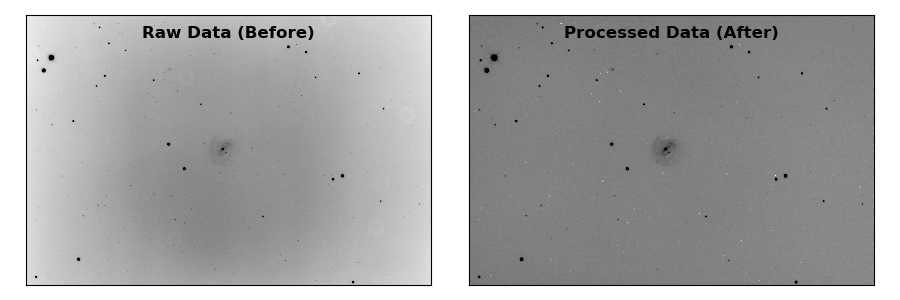

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(9,3))
for i, sci_data in enumerate([sci_data0, sci_data1]):
    ax = axs[i]
    vmin, vmax = interval.get_limits(sci_data)
    ax.imshow(sci_data, cmap='gray_r', origin='lower', vmin=vmin, vmax=vmax)
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
    if (i == 0):
        title = "Raw Data (Before)"
    else:
        title = "Processed Data (After)"
    ax.text(0.50, 0.96, title, fontsize=12.0, fontweight='bold',
        transform=ax.transAxes, ha='center', va='top')
plt.tight_layout()

In [24]:
fits.writeto("NGC3367_R_processed.fits", sci_data1, sci_hdr, overwrite=True)